# 1) faccio tutti i passaggi di analisi classici di adata (senza h1975)

In [1]:
import scanpy as sc
import pandas as pd
import pickle
import numpy as np
import graph_tool.all as gt
%matplotlib inline
%pylab
import pickle

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import anndata

In [3]:
adata=sc.read('adata_10x/adata_sc_10x.h5ad')
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20) #### df con i 20 geni significativi per gruppo
cell_annotation= pd.read_table('../sc_mixology/data/csv/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]
adata_4 = adata[adata.obs.cell_line != "H1975"]
adata_4

View of AnnData object with n_obs × n_vars = 722 × 1596 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'cell_line'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

### a) creo il grafo non weighted con adata_4 (sono 4 linee cellulari  perchè ho tolto h1975)

In [9]:
import graph_tool.all as gt
g = gt.Graph(directed=False)

In [11]:
adj=adata_4.uns['neighbors']['connectivities']
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [14]:
pickle.dump(g, open("adata_10x/10x_adata_4/10x_graph_g_4.pkl", "wb"), 2)

In [4]:
g = pickle.load( open( "adata_10x/10x_adata_4/10x_graph_g_4.pkl", "rb" ) ) #ho gia il grafo caricato

In [28]:
state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
pickle.dump(state,open('adata_10x/10x_adata_4/state_4.pkl', 'wb'),2)
state

<NestedBlockState object, with base <BlockState object with 53 blocks (53 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f81493dbcd0>, at 0x7f81344092d0>, and 5 levels of sizes [(722, 53), (53, 11), (11, 3), (3, 2), (2, 1)] at 0x7f8133345210>

In [5]:
state = pickle.load( open('adata_10x/10x_adata_4/state_4.pkl', "rb" ) )

<IPython.core.display.Javascript object>


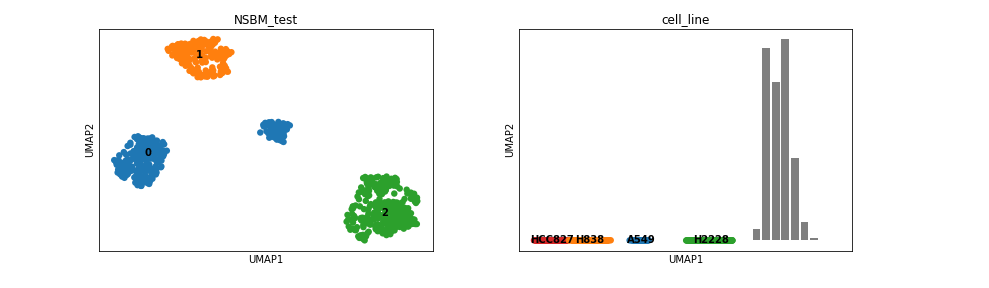

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
0,62,0,1,188
1,0,176,0,0
2,0,0,295,0


In [30]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### b) faccio mcmc_equilibrate()

In [43]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(niter=10000, d=0.1)

In [44]:
state

<NestedBlockState object, with base <BlockState object with 55 blocks (53 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f81493dbcd0>, at 0x7f8132d2eb50>, and 10 levels of sizes [(722, 53), (53, 14), (14, 4), (4, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7f8132d2eb10>

In [41]:
#collect_num_groups
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
        B = sl.get_nonempty_B()
        h[l][B] += 1
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)

(16537.955514389043, 81236797, 25656265)

In [42]:
pickle.dump(state,open('adata_10x/10x_adata_4/equilibrate_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/h_4.pkl', 'wb'),2)

In [43]:
s = state

<NestedBlockState object, with base <BlockState object with 56 blocks (55 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f4166d090>, and 10 levels of sizes [(722, 55), (55, 17), (17, 7), (7, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1)] at 0x7f6f417442d0>

<IPython.core.display.Javascript object>


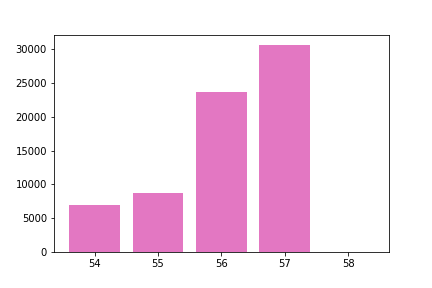

<IPython.core.display.Javascript object>


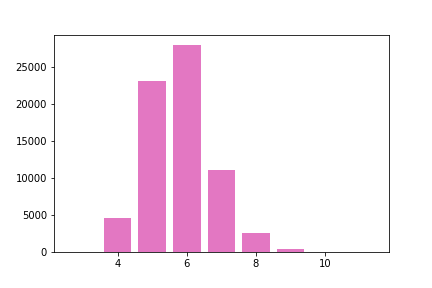

<IPython.core.display.Javascript object>


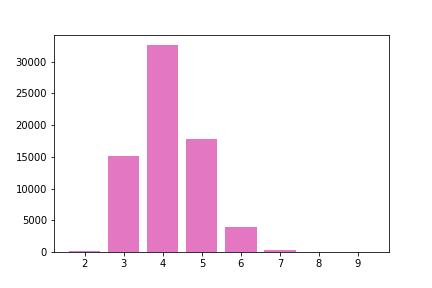

<IPython.core.display.Javascript object>


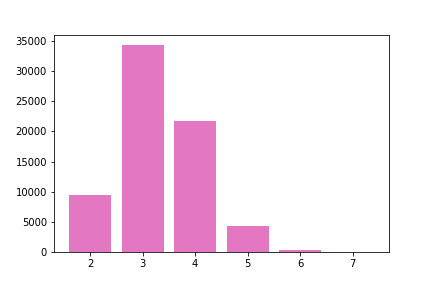

<IPython.core.display.Javascript object>


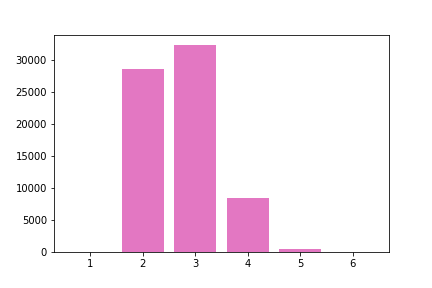

<IPython.core.display.Javascript object>


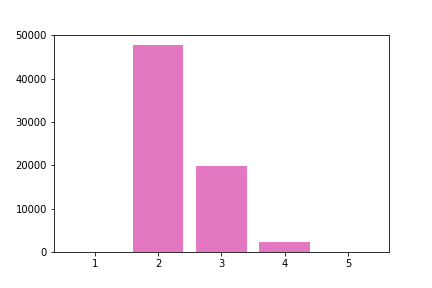

<IPython.core.display.Javascript object>


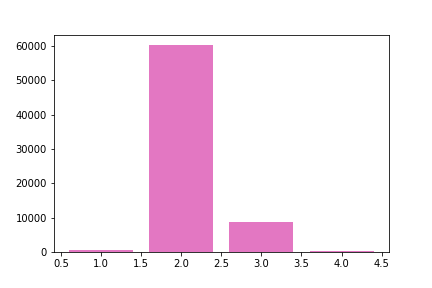

<IPython.core.display.Javascript object>


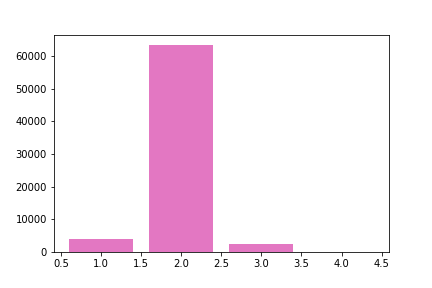

<IPython.core.display.Javascript object>


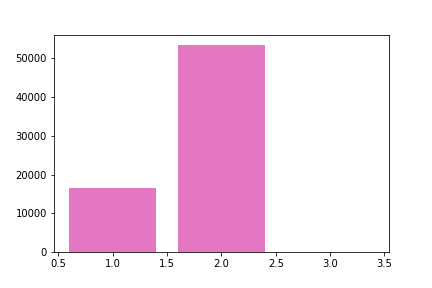

In [44]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

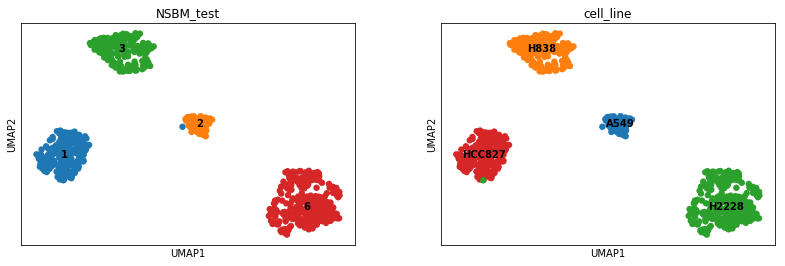

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
1,1,0,1,188
2,61,0,0,0
3,0,176,0,0
6,0,0,295,0


In [45]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

In [37]:
s = state.get_levels()[0]

In [38]:
[x for x in s.collect_vertex_marginals()]

[array([1], dtype=int32),
 array([0, 1], dtype=int32),
 array([1], dtype=int32),
 array([0, 1], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([0, 0, 1], dtype=int32),
 array([0, 1], dtype=int32),
 array([0, 1], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       dtype=int32),
 array([0, 0, 1], dtype=int32),
 array([1], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32),
 array([0, 0, 0, 0, 0, 1], dtype=int32),
 array([1], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 1], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32),
 array([0, 0, 1], dtype=int32),
 array([1], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32),
 array([1], dtype=int

In [42]:
state.get_bs()[0]

PropertyArray([ 0,  1,  0,  1,  0,  0,  2,  1,  1, 20,  2,  0, 33,  5,  0,
                8,  7,  8,  2,  0,  9, 14,  8,  0,  0, 11, 12, 13, 19,  0,
                2,  6, 14,  2, 15, 13,  2,  0, 14,  2,  2, 17, 20, 17,  2,
               18,  0, 12,  3, 17,  2, 36,  0,  9, 18,  5, 19,  0, 11,  8,
                0,  3,  0,  8,  8,  2, 20,  9, 47,  2, 21, 22,  7, 10, 18,
               24,  0,  8, 25, 21,  3, 17,  9, 12, 24, 21, 17,  2,  2, 22,
               26,  0,  0, 11, 24, 20, 25, 27, 28,  2,  3, 25, 29,  9,  2,
               30, 31, 38, 13, 12, 22, 34, 35,  1, 20, 20, 29,  5, 30, 15,
                2,  2, 23,  5, 11, 22, 32,  3, 21, 11, 37,  6, 17, 17, 25,
               17, 18, 33, 38, 47, 38, 13,  4, 39, 22, 27, 20, 25, 45, 17,
               30, 21, 33, 35, 33, 28, 19, 32, 13, 10, 26, 33, 13, 24, 23,
               23, 40, 13, 15, 41, 40, 19, 19, 26, 32, 32,  3, 12, 13, 31,
               40, 31, 38, 25, 30, 30,  4, 22, 42,  4, 17, 17,  3, 24, 10,
               20, 23, 18

<IPython.core.display.Javascript object>


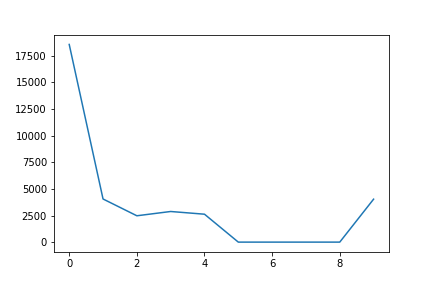

In [46]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

# 2) modifico i parametri c e d in mcmc_sweep()
### il parametro d: di default è 0.01, io lo provo a 0.01,0.02,0.05,0.1,0.15,0.20. questo parametro definisce la probabilità di selezionare un nuovo gruppo per una determinata mossa
### il parametro c: di default è 1, io lo proverò portandolo verso 0. For c→0 the blocks are sampled according to the local neighborhood of a given node and their block connections; for c→∞ the blocks are sampled randomly. 
### a) d=0.01

In [51]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(d=0.01,niter=1000)

In [ ]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/d_01_state_4.pkl', 'wb'),2)

pickle.dump(h,open('adata_10x/10x_adata_4/h_01_4.pkl', 'wb'),2)

In [27]:
state = pickle.load(open("adata_10x/10x_adata_4/d_01_state_4.pkl", "rb"))

In [54]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

<IPython.core.display.Javascript object>


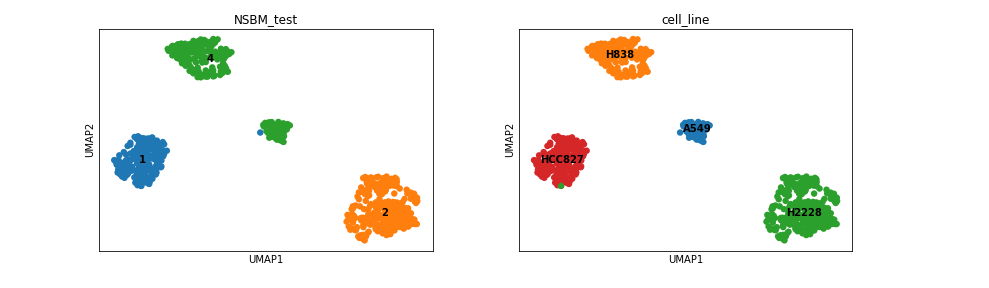

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
1,1,0,1,188
2,0,0,295,0
4,61,176,0,0


In [58]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(5).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

<IPython.core.display.Javascript object>


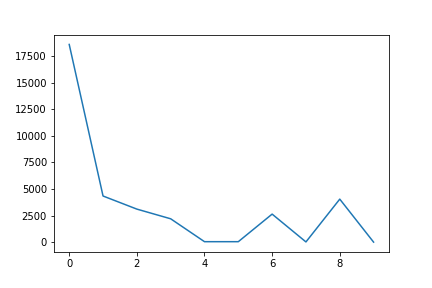

In [56]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

### b) d=0.02

In [59]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(d=0.02,niter=1000)

In [60]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/d_02_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/h_02_4.pkl', 'wb'),2)

In [61]:
state

<NestedBlockState object, with base <BlockState object with 57 blocks (56 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f419c09d0>, and 10 levels of sizes [(722, 56), (56, 16), (16, 6), (6, 3), (3, 3), (3, 3), (3, 2), (2, 2), (2, 2), (2, 1)] at 0x7f6f419c0750>

In [62]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

<IPython.core.display.Javascript object>


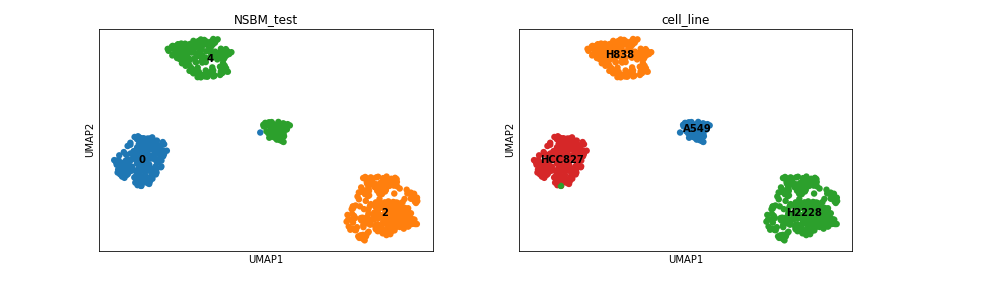

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
0,1,0,1,188
2,0,0,295,0
4,61,176,0,0


In [67]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(5).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

<IPython.core.display.Javascript object>


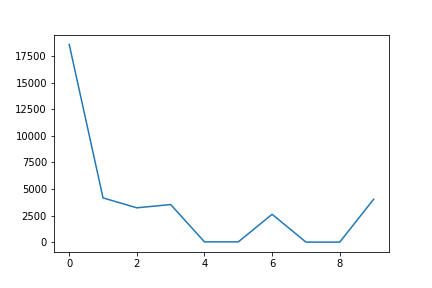

In [64]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

### c) d=0.05

In [68]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(d=0.05,niter=1000)

In [69]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/d_05_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/h_05_4.pkl', 'wb'),2)

In [70]:
state

<NestedBlockState object, with base <BlockState object with 58 blocks (57 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f40c9d550>, and 10 levels of sizes [(722, 57), (57, 14), (14, 4), (4, 3), (3, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f40d89f10>

In [71]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

<IPython.core.display.Javascript object>


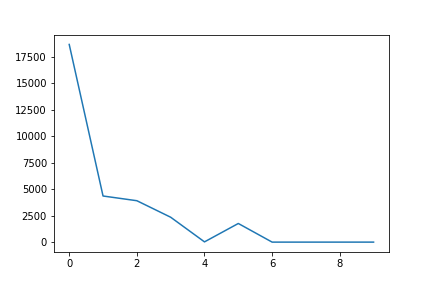

In [72]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


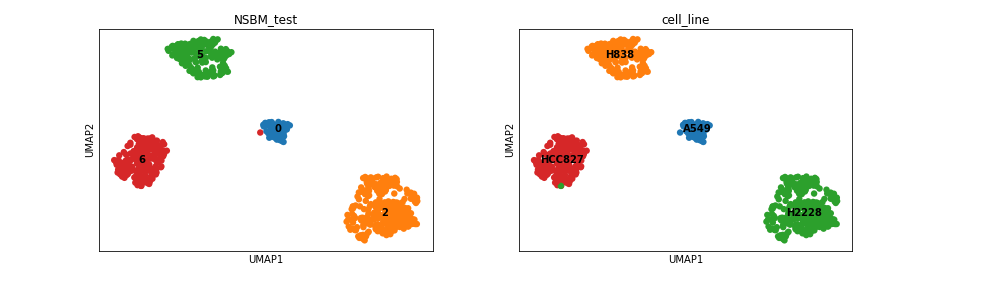

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
0,61,0,0,0
2,0,0,295,0
5,0,176,0,0
6,1,0,1,188


In [77]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### d) d=0.1

In [78]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(d=0.1,niter=1000)

In [79]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/d_10_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/h_10_4.pkl', 'wb'),2)

In [80]:
state

<NestedBlockState object, with base <BlockState object with 59 blocks (57 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f3ba36390>, and 10 levels of sizes [(722, 57), (57, 13), (13, 5), (5, 3), (3, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f3ba36250>

In [81]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

<IPython.core.display.Javascript object>


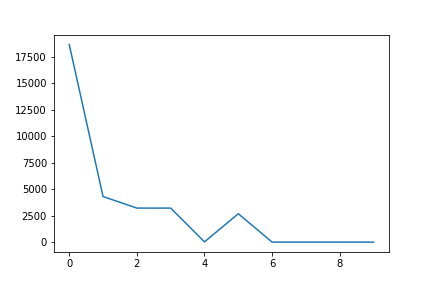

In [82]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


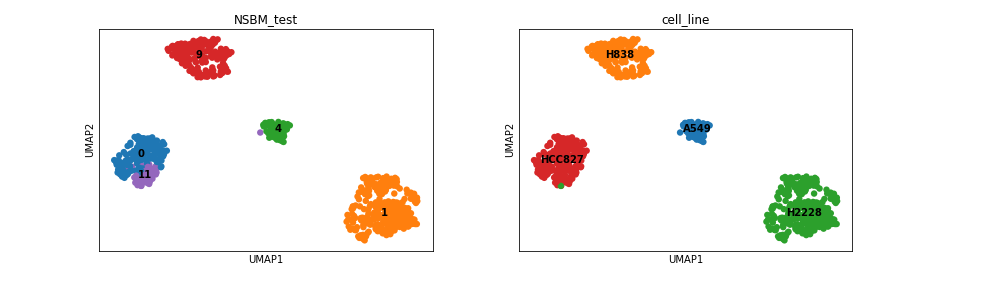

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
0,0,0,0,143
1,0,0,295,0
4,61,0,0,0
9,0,176,0,0
11,1,0,1,45


In [86]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### e) d= 0.15

In [87]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(d=0.15,niter=1000)

In [88]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/d_15_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/h_15_4.pkl', 'wb'),2)

In [89]:
state

<NestedBlockState object, with base <BlockState object with 58 blocks (57 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f3ba7ec90>, and 10 levels of sizes [(722, 57), (57, 13), (13, 4), (4, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1)] at 0x7f6f40b5f350>

In [90]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


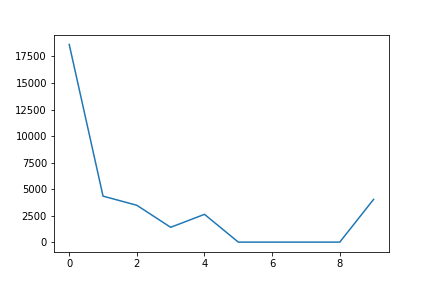

In [91]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


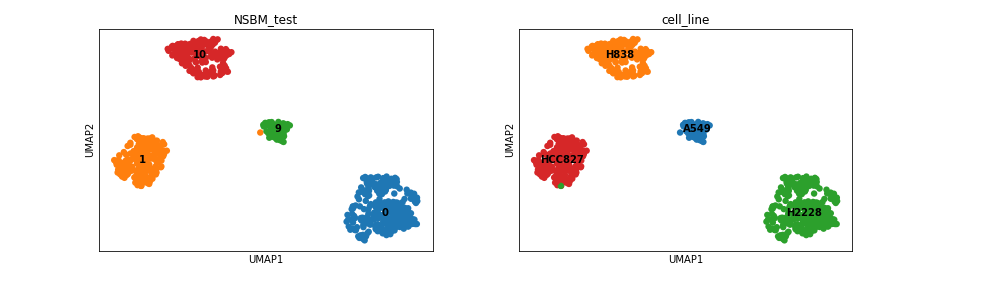

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
0,0,0,295,0
1,1,0,1,188
9,61,0,0,0
10,0,176,0,0


In [94]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### f) d=0.2

In [95]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(d=0.2,niter=1000)

In [96]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/d_20_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/h_20_4.pkl', 'wb'),2)

In [97]:
state

<NestedBlockState object, with base <BlockState object with 58 blocks (57 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f3b615890>, and 10 levels of sizes [(722, 57), (57, 15), (15, 7), (7, 5), (5, 3), (3, 3), (3, 3), (3, 2), (2, 2), (2, 2)] at 0x7f6f3b81c290>

In [98]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

<IPython.core.display.Javascript object>


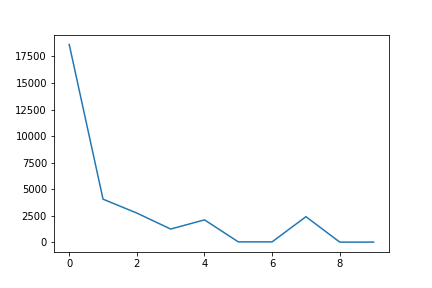

In [99]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


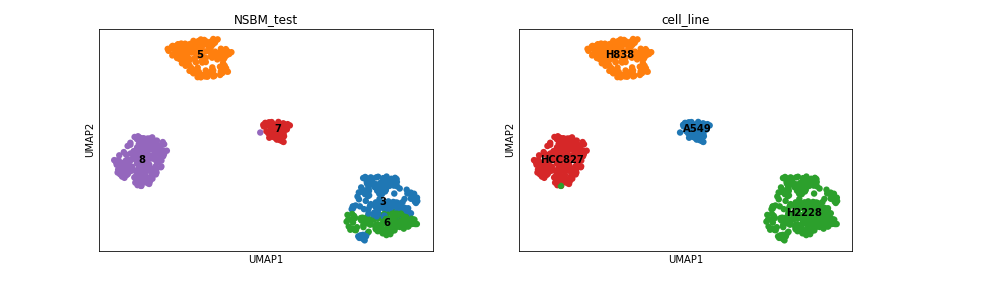

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
3,0,0,174,0
5,0,176,0,0
6,0,0,121,0
7,61,0,0,0
8,1,0,1,188


In [102]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(3).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### ora cambio il parametro c
### a) c=1

In [118]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=1.0,niter=1000)

In [119]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c100_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c100_4.pkl', 'wb'),2)

In [120]:
state

<NestedBlockState object, with base <BlockState object with 60 blocks (58 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f36238750>, and 10 levels of sizes [(722, 58), (58, 15), (15, 5), (5, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f36333d10>

In [121]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

<IPython.core.display.Javascript object>


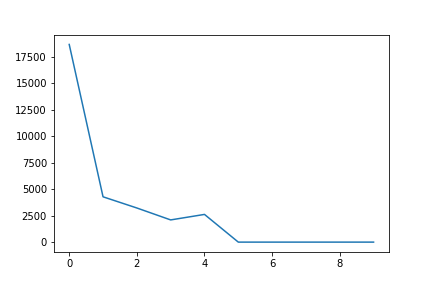

In [122]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


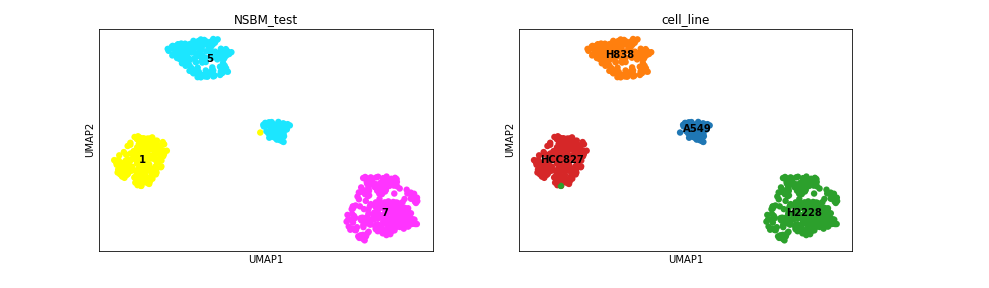

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
1,1,0,1,188
5,61,176,0,0
7,0,0,295,0


In [125]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(3).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### b) c=0.75

In [126]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.75,niter=1000)

In [127]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c75_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c75_4.pkl', 'wb'),2)

In [128]:
state

<NestedBlockState object, with base <BlockState object with 60 blocks (58 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f3620f350>, and 10 levels of sizes [(722, 58), (58, 14), (14, 5), (5, 4), (4, 3), (3, 3), (3, 3), (3, 3), (3, 2), (2, 1)] at 0x7f6f3620fc10>

<IPython.core.display.Javascript object>


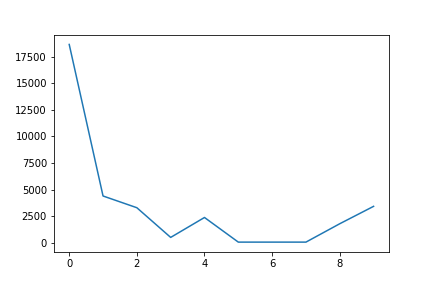

In [129]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


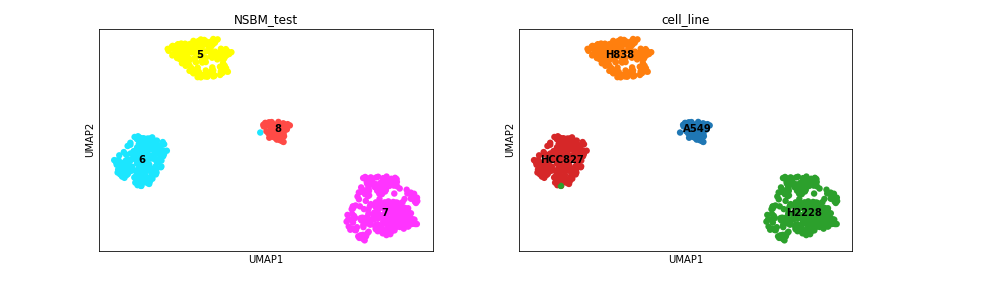

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
5,0,176,0,0
6,1,0,1,188
7,0,0,295,0
8,61,0,0,0


In [131]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(3).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

##### questa è la prima volta in cui il livello con minor entropia, corrisponde anche al livello con la suddivisione corretta sia per numero di gruppi sia per le cellule corrette in ogni gruppo
### b1) riprovo

In [185]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.75,niter=1000)
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c75b_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c75b_4.pkl', 'wb'),2)

In [186]:
state

<NestedBlockState object, with base <BlockState object with 61 blocks (58 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f353d3910>, and 10 levels of sizes [(722, 58), (58, 16), (16, 6), (6, 3), (3, 3), (3, 3), (3, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f353d3390>

<IPython.core.display.Javascript object>


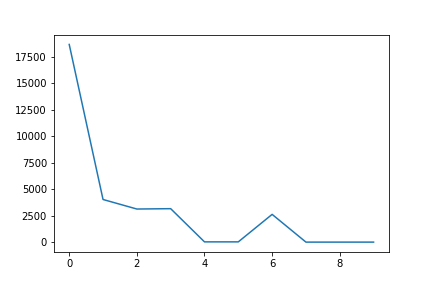

In [187]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


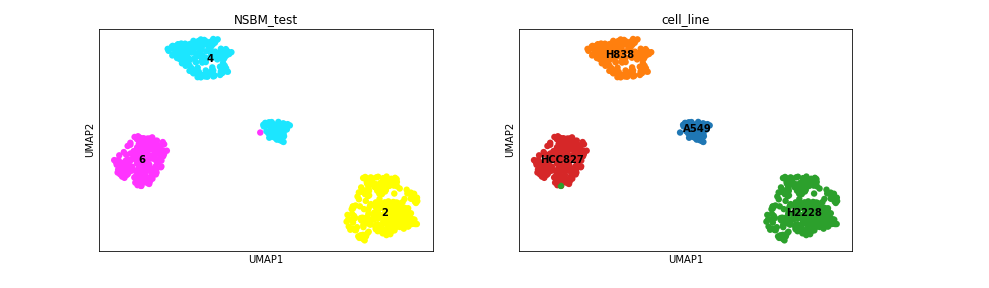

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
2,0,0,295,0
4,61,176,0,0
6,1,0,1,188


In [190]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(5).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

##### non è venuto ne il profilo di entropia desiderato, ne la giusta suddivisione
### b2) riprovo

In [191]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.75,niter=1000)
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c75c_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c75c_4.pkl', 'wb'),2)

In [192]:
state

<NestedBlockState object, with base <BlockState object with 62 blocks (58 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f354cd8d0>, and 10 levels of sizes [(722, 58), (58, 15), (15, 6), (6, 4), (4, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f354cd290>

<IPython.core.display.Javascript object>


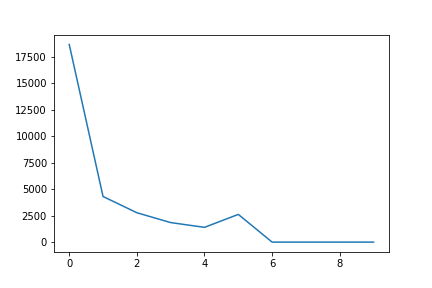

In [193]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


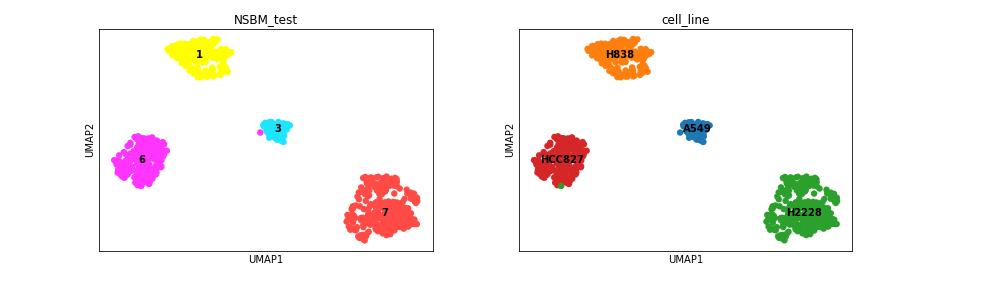

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
1,0,176,0,0
3,61,0,0,0
6,1,0,1,188
7,0,0,295,0


In [194]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(3).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### b3) riprovo

In [195]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.75,niter=1000)
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c75d_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c75d_4.pkl', 'wb'),2)

In [196]:
state

<NestedBlockState object, with base <BlockState object with 61 blocks (60 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f352e69d0>, and 10 levels of sizes [(722, 60), (60, 14), (14, 7), (7, 5), (5, 3), (3, 3), (3, 3), (3, 3), (3, 2), (2, 2)] at 0x7f6f3577ac50>

<IPython.core.display.Javascript object>


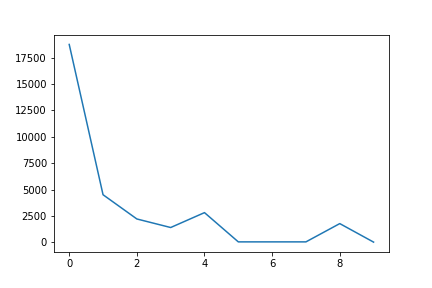

In [197]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


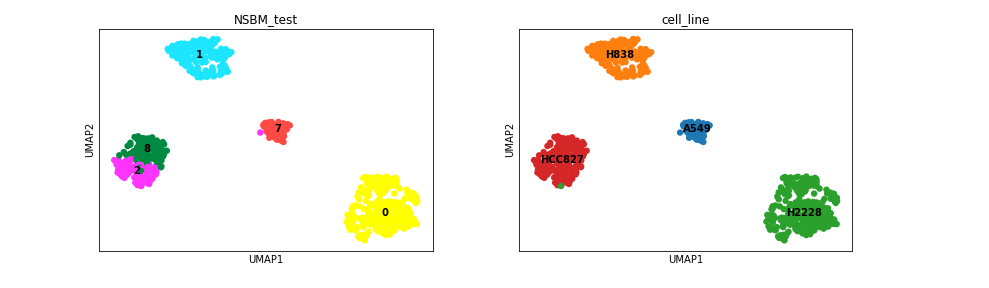

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
0,0,0,295,0
1,0,176,0,0
2,1,0,1,90
7,61,0,0,0
8,0,0,0,98


In [198]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(3).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### c) c=0.5

In [132]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.5,niter=1000)

In [133]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c50_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c50_4.pkl', 'wb'),2)

In [134]:
state

<NestedBlockState object, with base <BlockState object with 60 blocks (58 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f3b6d3fd0>, and 10 levels of sizes [(722, 58), (58, 16), (16, 6), (6, 6), (6, 4), (4, 4), (4, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f408a9550>

<IPython.core.display.Javascript object>


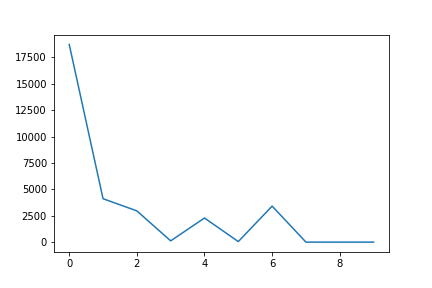

In [135]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


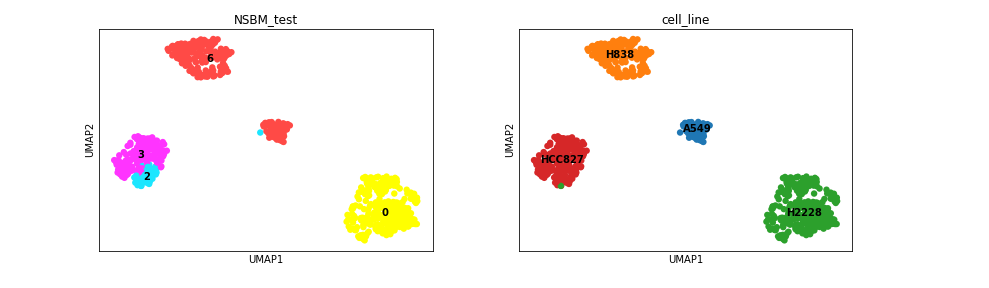

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
0,0,0,295,0
2,1,0,1,40
3,0,0,0,148
6,61,176,0,0


In [138]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(4).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### d) c=0.25

In [139]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.25,niter=1000)

In [140]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c25_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c25_4.pkl', 'wb'),2)

In [141]:
state

<NestedBlockState object, with base <BlockState object with 62 blocks (60 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f3625f8d0>, and 10 levels of sizes [(722, 60), (60, 15), (15, 7), (7, 6), (6, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f3625f410>

<IPython.core.display.Javascript object>


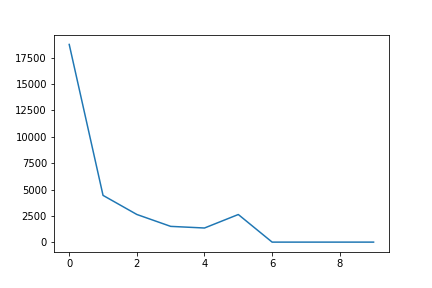

In [142]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


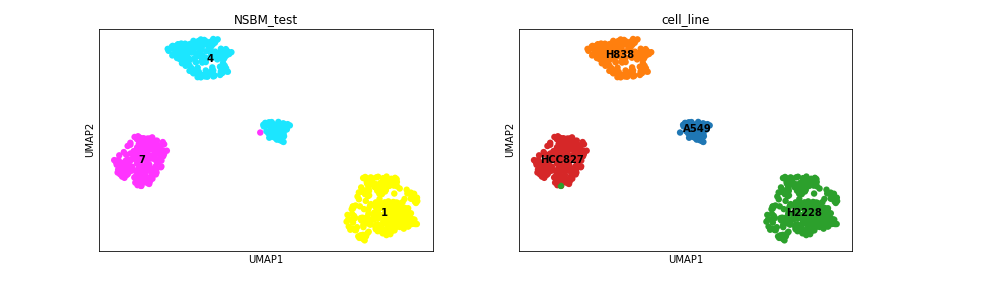

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
1,0,0,295,0
4,61,176,0,0
7,1,0,1,188


In [146]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(4).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### e) c=0.1

In [147]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.1,niter=1000)

In [148]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c10_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c10_4.pkl', 'wb'),2)

In [149]:
state

<NestedBlockState object, with base <BlockState object with 64 blocks (60 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f35d48a10>, and 10 levels of sizes [(722, 60), (60, 15), (15, 6), (6, 4), (4, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f35d48c50>

<IPython.core.display.Javascript object>


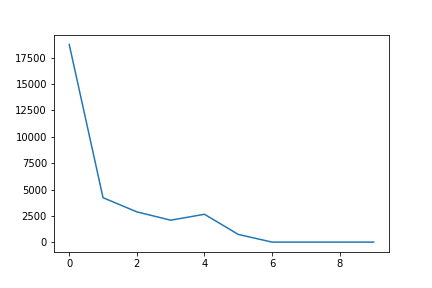

In [150]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


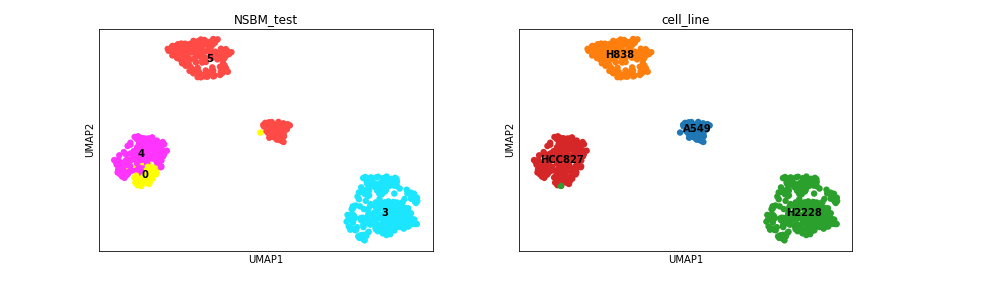

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
0,1,0,1,44
3,0,0,295,0
4,0,0,0,144
5,61,176,0,0


In [152]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(3).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### f) c=0.05

In [153]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.05,niter=1000)

In [154]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c005_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c005_4.pkl', 'wb'),2)

In [155]:
state

<NestedBlockState object, with base <BlockState object with 62 blocks (59 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f36369a90>, and 10 levels of sizes [(722, 59), (59, 15), (15, 8), (8, 4), (4, 4), (4, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f35caf810>

<IPython.core.display.Javascript object>


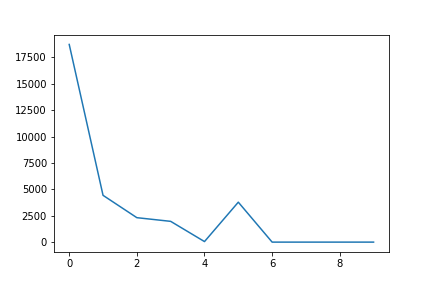

In [156]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


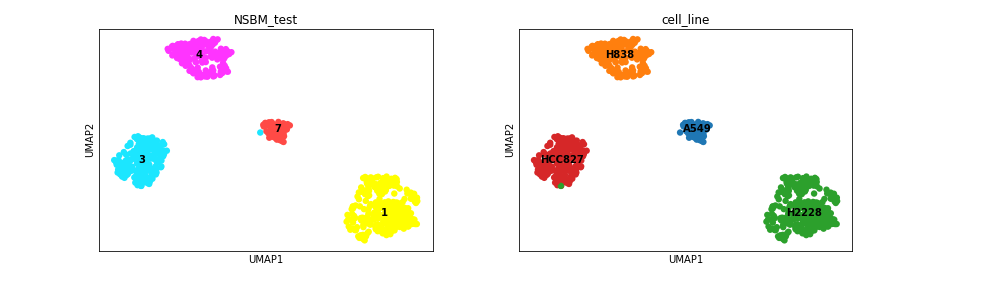

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
1,0,0,295,0
3,1,0,1,188
4,0,176,0,0
7,61,0,0,0


In [158]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(4).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

##### questa è la seconda volta in cui il livello con minor entropia, corrisponde anche al livello con la suddivisione corretta sia per numero di gruppi sia per le cellule corrette in ogni gruppo
##### QUELLO CHE SI NOTA È CHE SI OTTIENE LA SUDDIVISIONE CORRETTA, SOLO QUANDO IL PROFILO DELL'ENTROPIA HA LE SEGUAENTI CARATTERISTICHE: A) SCENDE A PICCO FINO AD UN LIVELLO INTERMEDIO DI ENTROPIA MINIMA B) RISALE DOPO QUESTO PICCO SOLO PER UN LIVELLO C) SCENDE NUOVAMENTE A LIVELLI DI ENTROPIA BASSISSIMI (SIMILI A QUELLO DI ENTROPIA MINIMA, MA QUI I GRUPPI SONO PALESEMENTE SBAGLIATI)
### fb) rifaccio e vedo come viene

In [167]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.05,niter=1000)
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c005b_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c005b_4.pkl', 'wb'),2)

In [168]:
state

<NestedBlockState object, with base <BlockState object with 62 blocks (59 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f35ce0090>, and 10 levels of sizes [(722, 59), (59, 16), (16, 6), (6, 5), (5, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f363c4f90>

<IPython.core.display.Javascript object>


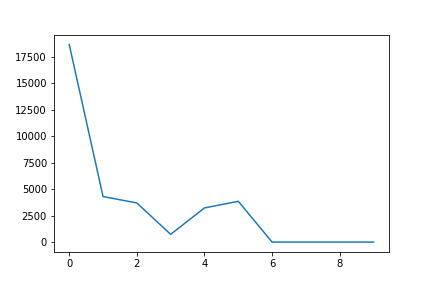

In [169]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


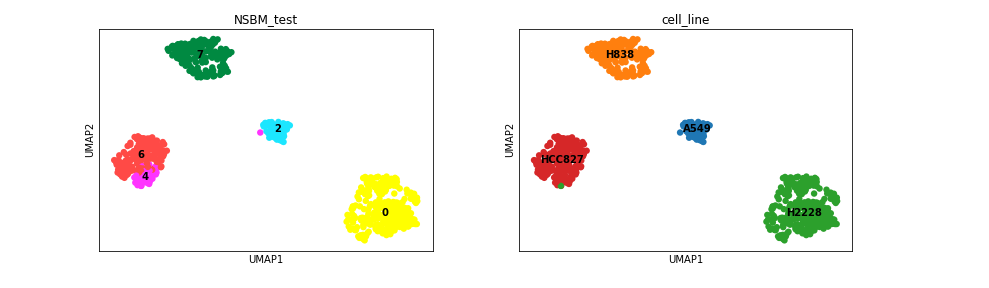

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
0,0,0,295,0
2,61,0,0,0
4,1,0,1,37
6,0,0,0,151
7,0,176,0,0


In [171]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(3).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

##### in qusto caso il profilo dell'entropia non è come nel precedente, quindi la scelta con entropia minore è simile alla ground thruth, ma viene individuato un gruppo in più
### fc) rifaccio

In [172]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.05,niter=1000)
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c005c_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c005c_4.pkl', 'wb'),2)

In [173]:
state

<NestedBlockState object, with base <BlockState object with 62 blocks (60 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f35ce06d0>, and 10 levels of sizes [(722, 60), (60, 16), (16, 7), (7, 4), (4, 3), (3, 3), (3, 2), (2, 2), (2, 2), (2, 2)] at 0x7f6f363e1350>

<IPython.core.display.Javascript object>


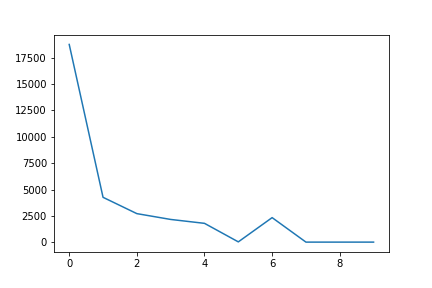

In [174]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


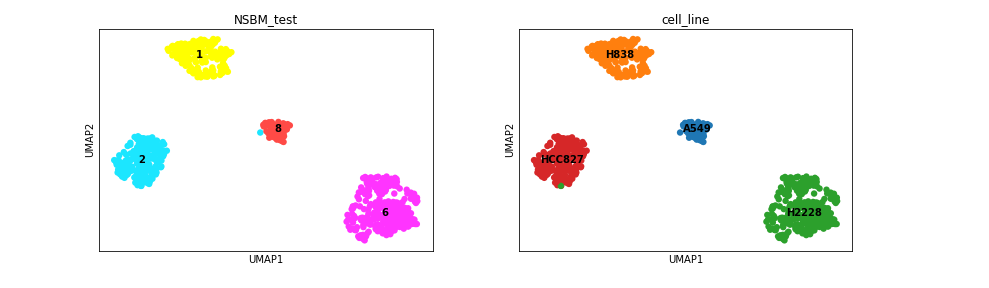

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
1,0,176,0,0
2,1,0,1,188
6,0,0,295,0
8,61,0,0,0


In [178]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(3).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

##### nonostante in questo caso il profilo di entropia sia corretto, il punto minore di entropia non corrisponde al livello che spiega correttamente la suddivisione delle cellule. 
##### FORSE IL PROFILO CORRETTO DI ENTROPIA GARANTISCE CHE CI SIA UN LIVELLO NEL NESTED OBJECT , CHE SPIEGA BENE I DATI, MA NON SI TRATTA PER FORZA DI QUELLO A MINOR ENTROPIA, BENSÌ SI TRATTA DI UN LIVELLO PROSSIMO O COINCIDENTE CON QUESTO
### fd) rifaccio

In [179]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.05,niter=1000)
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c005d_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c005d_4.pkl', 'wb'),2)

In [180]:
state

<NestedBlockState object, with base <BlockState object with 62 blocks (58 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f6f7302f750>, at 0x7f6f35812290>, and 10 levels of sizes [(722, 58), (58, 16), (16, 5), (5, 5), (5, 4), (4, 4), (4, 3), (3, 3), (3, 2), (2, 2)] at 0x7f6f35812950>

<IPython.core.display.Javascript object>


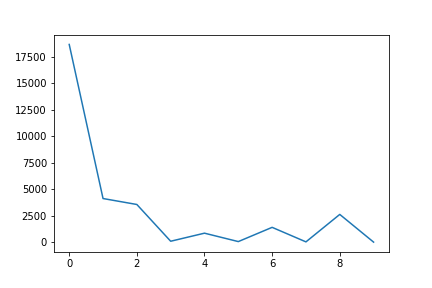

In [181]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

<IPython.core.display.Javascript object>


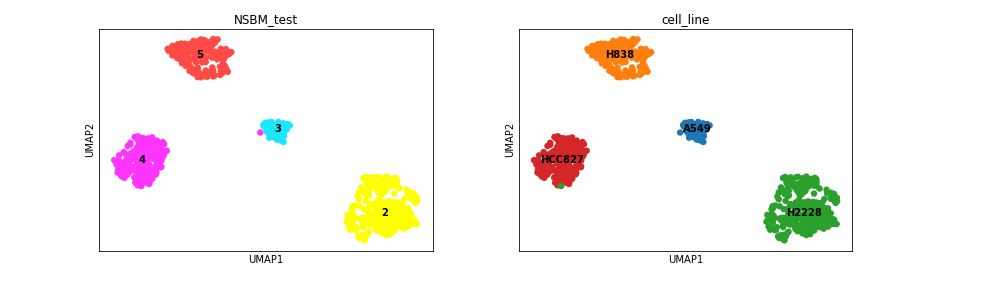

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
2,0,0,295,0
3,61,0,0,0
4,1,0,1,188
5,0,176,0,0


In [184]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(5).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

##### IL PROFILO DI ENTROPIA QUI NON È COME I PRECEDENTI, NONOSTANTE CIÒ, C'È UN LIVELLO CHE SPIEGA CORRETTAMENTE I DATI. QUINDI PROBABILMENTE È QUESTO LIVELLO DI PARAMETRO C CHE CONTRIBUISCE AD UNA MIGLIORE SPIEGAZIONE. PROVO CON C =0.75 CHE ERA VENUTO CORRETTAMENTE

### g) c=0.01

In [15]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.01,niter=1000)

In [16]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c001_state_4b.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c001_4b.pkl', 'wb'),2)

In [17]:
state

<NestedBlockState object, with base <BlockState object with 60 blocks (58 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f81347d7550>, at 0x7f8131b35bd0>, and 10 levels of sizes [(722, 58), (58, 16), (16, 6), (6, 4), (4, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7f8131b74e90>

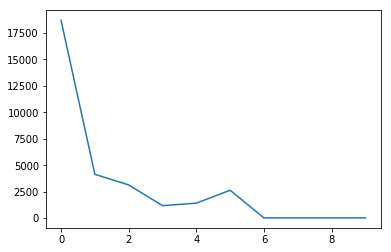

In [18]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

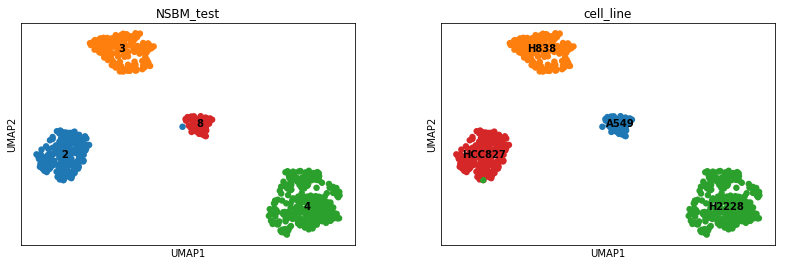

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
2,1,0,1,188
3,0,176,0,0
4,0,0,295,0
8,61,0,0,0


In [21]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(3).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### g2) rifaccio c=0.01

In [6]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.01,niter=1000)

In [7]:
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
        B = sl.get_nonempty_B()
        h[l][B] += 1

In [8]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c001_state_4.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c001_4.pkl', 'wb'),2)

In [9]:
state

<NestedBlockState object, with base <BlockState object with 58 blocks (57 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f81347d7550>, at 0x7f8131b55110>, and 10 levels of sizes [(722, 57), (57, 16), (16, 5), (5, 5), (5, 4), (4, 3), (3, 2), (2, 2), (2, 2), (2, 2)] at 0x7f8131b55150>

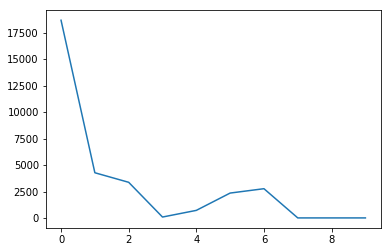

In [10]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

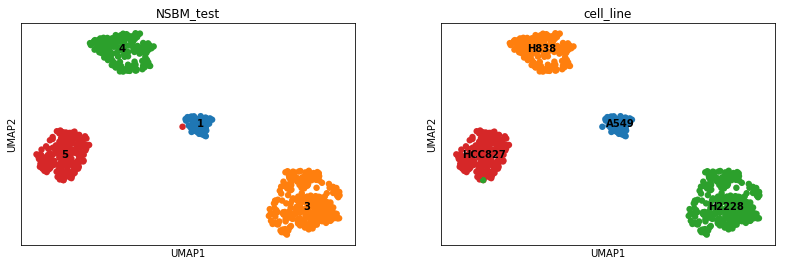

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
1,61,0,0,0
3,0,0,295,0
4,0,176,0,0
5,1,0,1,188


In [14]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(4).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)

### g3) rifaccio c=0.01

In [22]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state.copy(bs=bs, sampling=True)
dS, nattempts, nmoves = state.mcmc_sweep(c=0.01,niter=1000)

In [23]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10), callback=collect_num_groups)
pickle.dump(state,open('adata_10x/10x_adata_4/c001_state_4c.pkl', 'wb'),2)
pickle.dump(h,open('adata_10x/10x_adata_4/c001_4c.pkl', 'wb'),2)

In [24]:
state

<NestedBlockState object, with base <BlockState object with 59 blocks (57 nonempty), for graph <Graph object, undirected, with 722 vertices and 5017 edges at 0x7f81347d7550>, at 0x7f8134526890>, and 10 levels of sizes [(722, 57), (57, 15), (15, 6), (6, 3), (3, 3), (3, 3), (3, 2), (2, 2), (2, 2), (2, 2)] at 0x7f8134526590>

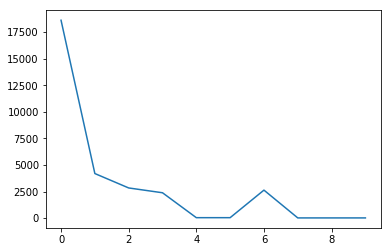

In [25]:
bl3 = [x.entropy() for x in state.get_levels()]
figure()
plot(range(len(bl3)), bl3)

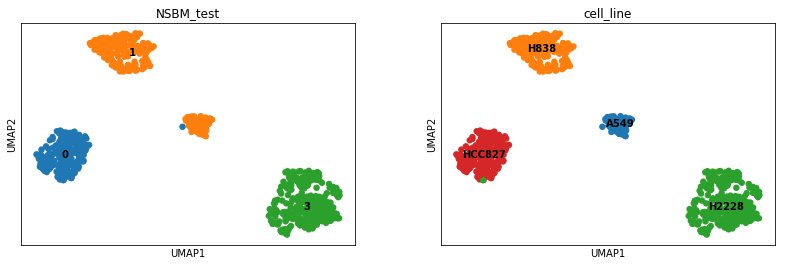

cell_line,A549,H838,H2228,HCC827
NSBM_test,,,,
0,1,0,1,188
1,61,176,0,0
3,0,0,295,0


In [26]:
adata_4.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(4).get_blocks()))
sc.pl.umap(adata_4, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata_4.obs.NSBM_test, adata_4.obs.cell_line)